# 0. Install Dependencies and Bring in Data

In [1]:
pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\drago\anaconda3\envs\pt\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\drago\anaconda3\envs\pt\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\drago\anaconda3\envs\pt\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
pip list

Package                   Version
------------------------- ---------
absl-py                   2.1.0
albumentations            1.4.6
altair                    5.3.0
annotated-types           0.6.0
anyio                     4.4.0
appdirs                   1.4.4
asttokens                 2.4.1
astunparse                1.6.3
attrs                     23.2.0
audioread                 3.0.1
beautifulsoup4            4.12.3
blinker                   1.7.0
cachetools                5.3.3
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
coloredlogs               15.0.1
comm                      0.1.4
comtypes                  1.4.2
contourpy                 1.2.0
cycler                    0.12.1
debugpy                   1.8.0
decorator                 5.1.1
distro                    1.9.0
exceptiongroup            1.2.0
executing                 2.0.1
filelock                  

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [63]:
# Check the contents and shapes of the datasets
for element in train.take(1):
    print(f"Train batch - X shape: {element[0].shape}, y shape: {element[1].shape}")

for element in val.take(1):
    print(f"Validation batch - X shape: {element[0].shape}, y shape: {element[1].shape}")

Train batch - X shape: (16, 1800), y shape: (16, 6)
Validation batch - X shape: (16, 1800), y shape: (16, 6)


# 2. Create Sequential Model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [54]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [55]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [59]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = None
try:
    history = model.fit(train, epochs=1, validation_data=val, verbose=1)
except Exception as e:
    print(f"An error occurred during training: {e}")
finally:
    if history:
        print("Training completed successfully")
        print(history.history)
    else:
        print("Training did not complete")

An error occurred during training: 'NoneType' object has no attribute 'items'
Training did not complete


In [67]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.layers import TextVectorization

# Ensure TensorFlow and Keras versions are up to date
print(f"TensorFlow version: {tf.__version__}")

# Load the dataset
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv', 'train.csv'))

# Prepare data
X = df['comment_text']
y = df[df.columns[2:]].values

MAX_FEATURES = 200000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset) * 0.7))
val = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

# Check the contents and shapes of the datasets
for element in train.take(1):
    print(f"Train batch - X shape: {element[0].shape}, y shape: {element[1].shape}")

for element in val.take(1):
    print(f"Validation batch - X shape: {element[0].shape}, y shape: {element[1].shape}")

# Build the model with input shape specified
model = Sequential()
model.add(Embedding(MAX_FEATURES + 1, 32, input_length=1800))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(6, activation='sigmoid'))  # Simplified model

model.compile(loss='binary_crossentropy', optimizer='adam')

# Print model summary
model.summary()

# Simplify the training and add detailed logging
history = None
try:
    print("Starting training...")
    history = model.fit(train, epochs=1, validation_data=val, verbose=1)
except Exception as e:
    print(f"An error occurred during training: {e}")
finally:
    if history:
        print("Training completed successfully")
        print(history.history)
    else:
        print("Training did not complete")


TensorFlow version: 2.17.0
Train batch - X shape: (16, 1800), y shape: (16, 6)
Validation batch - X shape: (16, 1800), y shape: (16, 6)


c:\Users\drago\anaconda3\envs\pt\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Starting training...
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2743s 392ms/step - loss: 0.0977 - val_loss: 0.0467
Training completed successfully
{'loss': [0.06792587041854858], 'val_loss': [0.046726010739803314]}


In [69]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,251,188 (73.44 MB)

 Trainable params: 6,417,062 (24.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,834,126 (48.96 MB)

In [30]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

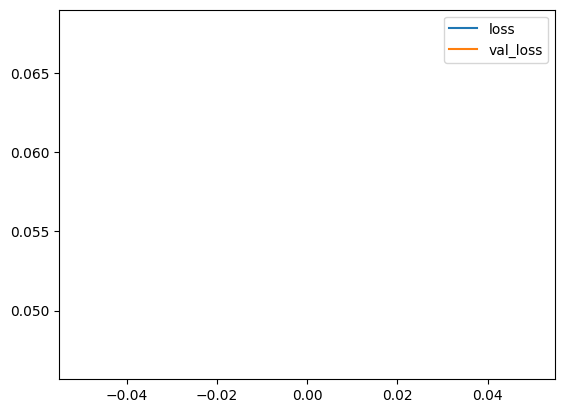

In [72]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()
#since weve only run one epoch so thats why this graph is empty 

# 3. Make Predictions

In [75]:
import numpy as np

# Preprocess input text
input_text = vectorizer(['You freaking suck! I am going to hit you.'])

# Ensure the input shape is compatible with the model
input_text = np.array(input_text)

# Make predictions
res = model.predict(input_text)

# Print predictions
print(f"Predicted probabilities: {res}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Predicted probabilities: [[0.9830471  0.18293251 0.87884504 0.03100376 0.80639577 0.16020362]]


In [76]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [77]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [78]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [79]:
res.shape

(1, 6)

# 4. Evaluate Model

In [80]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [82]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

In [83]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7778096199035645, Recall:0.7484138011932373, Accuracy:0.4663991928100586


# 5. Test and Gradio

In [84]:
pip install gradio jinja2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached python_multipart-0.0.9-py3-none-any.whl.metadata (2.5 kB)
  Using cached typer-0.12.3-py3-none-any.whl.metadata (15 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached starlette-0.37.2-py3-none-any.whl.metadata (5.9 kB)
  Using cached dnspython-2.6.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
   ---------------------------------------- 0.0/12.4 MB ? eta -:--:--
    --------------------------------------- 0.3/12.4 MB 8.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/12.4 MB 10.9 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/12.4 MB 10.0 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/12.4 MB 10.1 MB/s eta 0:00:02
   ----- -----------------------

In [85]:
import tensorflow as tf
import gradio as gr

c:\Users\drago\anaconda3\envs\pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
model.save('toxicity.keras')

In [89]:
input_str = vectorizer('hey i freaken hate you!')

In [90]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [91]:
res

array([[0.69943416, 0.0143058 , 0.20174976, 0.00991825, 0.22517493,
        0.03576374]], dtype=float32)

In [98]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [101]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs='text'
)

In [102]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1aff7cd4693e2d7605.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
